#### 數據包含1,338個案例，即目前已經登記過的保險計劃受益者、病人特點和計劃計入的總醫療費用特徵:

* age:表示主要受益者年齡
* sex:性別
* bmi:身體質量指數,理想BMI在18.5~24.9之間
* children:表示保險計劃中所包括的孩子/受撫養者的數量
* smoker:表示被保險人是否經常吸煙
* region:受益者在美國的居住地-東北(northeast), 東南(sotheast), 西南(southwest)和東北(northwest)
* charges:醫療費用

### 目的 : 檢測與醫療費用相關之變量，並預測醫療費用

In [1]:
# 工具
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_style('darkgrid')

import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from collections import Counter
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn import datasets, linear_model
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.linear_model import LinearRegression

In [2]:
df = pd.read_csv('insurance.csv')

### 觀察數據

In [3]:
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [4]:
# 確認資料型態及 NA 個數
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


### 資料預處理(資料轉換)

##### 類別變數轉換數值變數的選擇
1. 如果類別資料具有明確的順序（例如，評級 'low', 'medium', 'high'），則可以考慮使用 LabelEncoder。
2. 如果類別資料是無序的，則應該使用 One-Hot Encoding(dummy variable)。
3. 基於樹的模型（例如決策樹、隨機森林、XGBoost等）可以直接處理 LabelEncoded 的類別特徵而不會引入誤解。但對於線性模型、神經網路等，One-Hot Encoding 通常是更好的選擇。

#### One-Hot Encoding

In [5]:
# 轉換 dummy variable
df_dummies = pd.get_dummies(df, drop_first=True)
df_dummies.head()

,age,bmi,children,charges,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
0,19,27.900,0,16884.92400,False,True,False,False,True
1,18,33.770,1,1725.55230,True,False,False,True,False
2,28,33.000,3,4449.46200,True,False,False,True,False
3,33,22.705,0,21984.47061,True,False,True,False,False
4,32,28.880,0,3866.85520,True,False,True,False,False


In [6]:
# 將 bool轉換為 int
bool_cols = ['sex_male', 'smoker_yes', 'region_northwest', 'region_southeast', 'region_southwest']
df_dummies[bool_cols] = df_dummies[bool_cols].astype(int)
df_dummies.head()

,age,bmi,children,charges,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
0,19,27.900,0,16884.92400,0,1,0,0,1
1,18,33.770,1,1725.55230,1,0,0,1,0
2,28,33.000,3,4449.46200,1,0,0,1,0
3,33,22.705,0,21984.47061,1,0,1,0,0
4,32,28.880,0,3866.85520,1,0,1,0,0


#### 同時嘗試使用 LabelEncoder ，比較結果有何差異

In [7]:
# 建立 LabelEncoder 物件
labelencoder = LabelEncoder()

In [8]:
df_label = df.copy()

# 將類別型變數轉為數值型
df_label['sex'] = labelencoder.fit_transform(df['sex'])
df_label['smoker'] = labelencoder.fit_transform(df['smoker'])
df_label['region'] = labelencoder.fit_transform(df['region'])
df_label

,age,sex,bmi,children,smoker,region,charges
0,19,0,27.900,0,1,3,16884.92400
1,18,1,33.770,1,0,2,1725.55230
2,28,1,33.000,3,0,2,4449.46200
3,33,1,22.705,0,0,1,21984.47061
4,32,1,28.880,0,0,1,3866.85520
...,...,...,...,...,...,...,...
1333,50,1,30.970,3,0,1,10600.54830
1334,18,0,31.920,0,0,0,2205.98080
1335,18,0,36.850,0,0,2,1629.83350
1336,21,0,25.800,0,0,3,2007.94500


#### 標準化

In [9]:
# 建立 MinMaxScaler 物件
minmax = preprocessing.MinMaxScaler()

# 資料標準化
df_dummies[['age', 'bmi', 'children']] = minmax.fit_transform(df_dummies[['age', 'bmi', 'children']])
df_label[['age', 'bmi', 'children']] = minmax.fit_transform(df_label[['age', 'bmi', 'children']])
df_dummies
# df_label

,age,bmi,children,charges,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
0,0.021739,0.321227,0.0,16884.92400,0,1,0,0,1
1,0.000000,0.479150,0.2,1725.55230,1,0,0,1,0
2,0.217391,0.458434,0.6,4449.46200,1,0,0,1,0
3,0.326087,0.181464,0.0,21984.47061,1,0,1,0,0
4,0.304348,0.347592,0.0,3866.85520,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...
1333,0.695652,0.403820,0.6,10600.54830,1,0,1,0,0
1334,0.000000,0.429379,0.0,2205.98080,0,0,0,0,0
1335,0.000000,0.562012,0.0,1629.83350,0,0,0,1,0
1336,0.065217,0.264730,0.0,2007.94500,0,0,0,0,1


In [10]:
df_dummies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   age               1338 non-null   float64
 1   bmi               1338 non-null   float64
 2   children          1338 non-null   float64
 3   charges           1338 non-null   float64
 4   sex_male          1338 non-null   int32  
 5   smoker_yes        1338 non-null   int32  
 6   region_northwest  1338 non-null   int32  
 7   region_southeast  1338 non-null   int32  
 8   region_southwest  1338 non-null   int32  
dtypes: float64(4), int32(5)
memory usage: 68.1 KB


In [11]:
df_label.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   float64
 1   sex       1338 non-null   int32  
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   float64
 4   smoker    1338 non-null   int32  
 5   region    1338 non-null   int32  
 6   charges   1338 non-null   float64
dtypes: float64(4), int32(3)
memory usage: 57.6 KB


In [12]:
df_dummies[['age','bmi','children','charges']].describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,0.461022,0.395572,0.218984,13270.422265
std,0.305434,0.164062,0.241099,12110.011237
min,0.000000,0.000000,0.000000,1121.873900
25%,0.195652,0.278080,0.000000,4740.287150
50%,0.456522,0.388485,0.200000,9382.033000
75%,0.717391,0.504002,0.400000,16639.912515
max,1.000000,1.000000,1.000000,63770.428010


In [13]:
df_dummies.columns

Index(['age', 'bmi', 'children', 'charges', 'sex_male', 'smoker_yes',
       'region_northwest', 'region_southeast', 'region_southwest'],
      dtype='object')

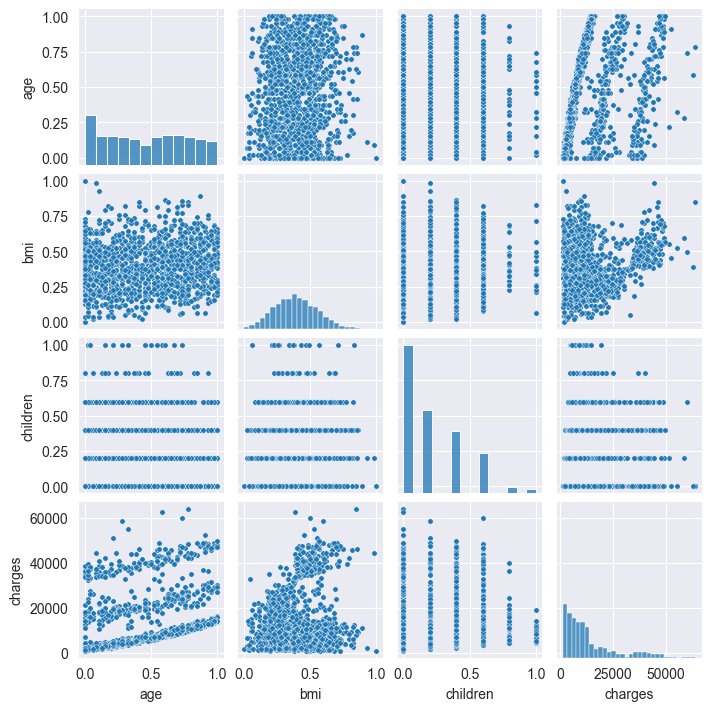

In [14]:
sns.pairplot(df_dummies[['age', 'bmi', 'children', 'charges']], height=1.8, plot_kws={'s': 15})

# age:表示主要受益者年齡
# sex:性別
# bmi:身體質量指數,理想BMI在18.5~24.9之間
# children:表示保險計劃中所包括的孩子/受撫養者的數量
# smoker:表示被保險人是否經常吸煙
# region:受益者在美國的居住地-東北(northeast), 東南(sotheast), 西南(southwest)和東北(northwest)
# charges:醫療費用

#### 檢查有無明顯共線性問題

<Axes: >

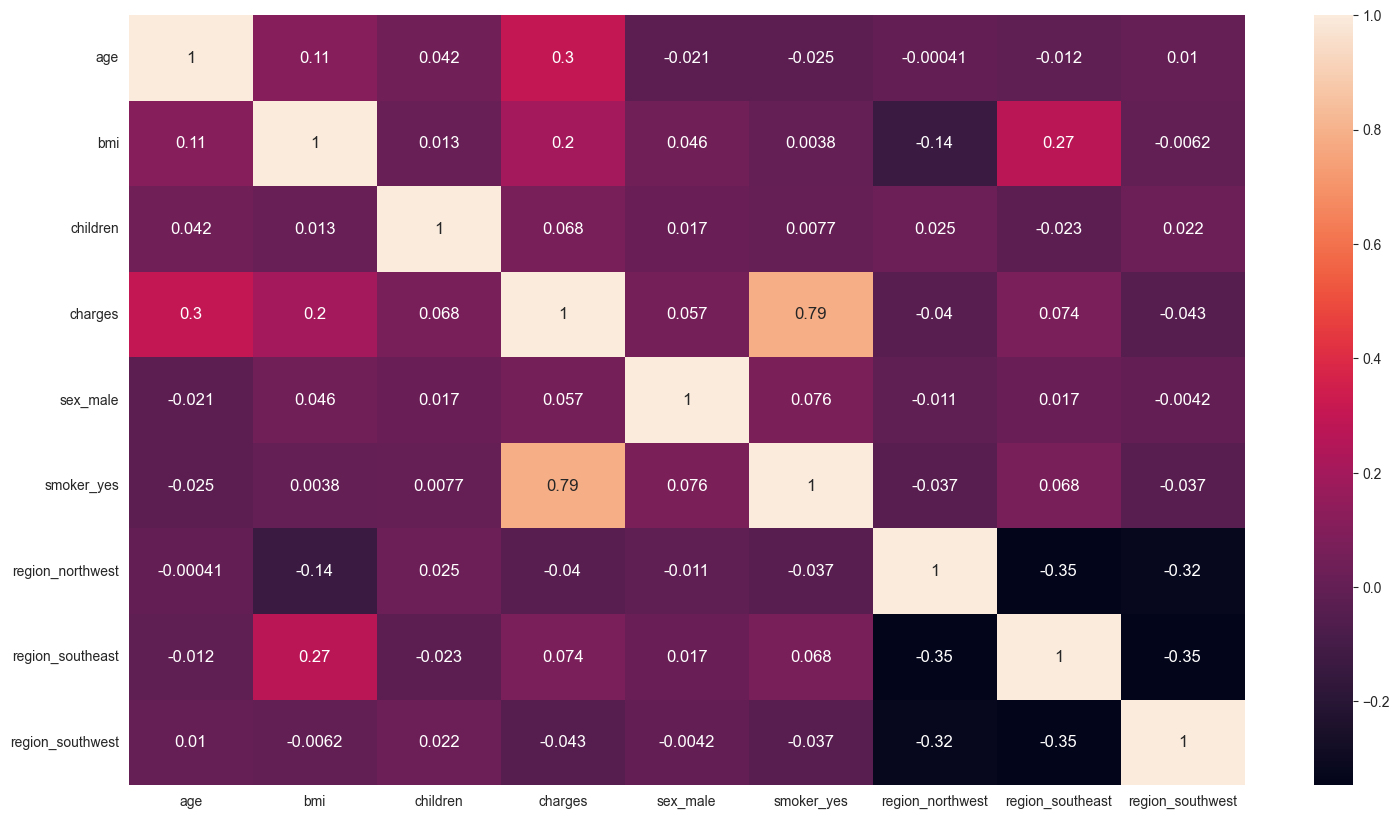

In [15]:
# 相關係數矩陣
corrmat = df_dummies.corr()

# 建立一個圖形和軸
fig, ax = plt.subplots(figsize = (18, 10))

# 畫熱度圖
sns.heatmap(corrmat, annot = True, annot_kws={'size': 12})  # annot=True 表示在熱度圖的每個單元格中顯示數字（相關係數的值）

##### 利用VIF值再檢查一次是否有共線性問題

In [16]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
# from statsmodels.tools.tools import add_constant
import statsmodels.api as sm

df_add_X = sm.add_constant(df_dummies)

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(df_add_X.values, i) for i in range(df_add_X.shape[1])]
vif["features"] = df_add_X.columns

print(vif.round(1))

# 通常 VIF大於 10，才會認定該變數具有共線性問題(常數項通常不考慮)

   VIF Factor          features
0        12.6             const
1         1.4               age
2         1.2               bmi
3         1.0          children
4         4.0           charges
5         1.0          sex_male
6         3.5        smoker_yes
7         1.5  region_northwest
8         1.7  region_southeast
9         1.5  region_southwest


#### 確認 X 與 y

In [17]:
# 設定特徵和標籤(dummy)
X = df_dummies.drop(columns=['charges']).values
y = df_dummies['charges'].values.reshape(-1, 1) # 轉換成 1 個 column

# 設定特徵和標籤(label)
X_label = df_label.drop(columns=['charges']).values
y_label = df_label['charges'].values.reshape(-1, 1) # 轉換成 1 個 column

In [18]:
# 分割訓練和測試(dummy)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 25)

# 分割訓練和測試(label)
X_tra, X_tes, y_tra, y_tes = train_test_split(X_label, y_label, test_size = 0.2, random_state = 25)

# Linear Regression

In [19]:
regressor_linear = LinearRegression()
regressor_linear.fit(X_train, y_train)

LinearRegression()

#### dummy

In [20]:
from sklearn.metrics import r2_score

# R2 score，反映 Y 的全部變異能透過迴歸關係被所有 X 解釋的比例。
y_pred_linear_train = regressor_linear.predict(X_train)
r2_score_linear_train = r2_score(y_train, y_pred_linear_train)

y_pred_linear_test = regressor_linear.predict(X_test)
r2_score_linear_test = r2_score(y_test, y_pred_linear_test)

# RMSE : 均方根誤差(標準誤差)，可衡量預測值和實際值之間的平均差異，藉此估計預測模型預測目標值的準確度
# RMSE 越小越好 (用來比較模型之間的差異)
rmse_train = (np.sqrt(mean_squared_error(y_train, y_pred_linear_train)))
rmse_test = (np.sqrt(mean_squared_error(y_test, y_pred_linear_test)))

print('R2_score (train): ', r2_score_linear_train)
print('R2_score (test): ', r2_score_linear_test)
print("RMSE(train): ", rmse_train)
print("RMSE(test): ", rmse_test)

R2_score (train):  0.7490732999835242
R2_score (test):  0.754703766445041
RMSE(train):  6091.27503365255
RMSE(test):  5885.00602631647


##### label

In [21]:
regressor_linear.fit(X_tra, y_tra)

LinearRegression()

In [22]:
# R2 score，反映 Y 的全部變異能透過迴歸關係被所有 X 解釋的比例。
y_pred_linear_tra = regressor_linear.predict(X_tra)
r2_score_linear_tra = r2_score(y_tra, y_pred_linear_tra)

y_pred_linear_tes = regressor_linear.predict(X_tes)
r2_score_linear_tes = r2_score(y_tes, y_pred_linear_tes)

# RMSE : 均方根誤差(標準誤差)，可衡量預測值和實際值之間的平均差異，藉此估計預測模型預測目標值的準確度
# RMSE 越小越好 (用來比較模型之間的差異)
rmse_tra = (np.sqrt(mean_squared_error(y_tra, y_pred_linear_tra)))
rmse_tes = (np.sqrt(mean_squared_error(y_tes, y_pred_linear_tes)))

print('R2_score (train): ', r2_score_linear_tra)
print('R2_score (test): ', r2_score_linear_tes)
print("RMSE(train): ", rmse_tra)
print("RMSE(test): ", rmse_tes)

R2_score (train):  0.7483825584860884
R2_score (test):  0.7575797365475684
RMSE(train):  6099.653187227242
RMSE(test):  5850.40499799718


### 利用詳細的統計分析做變數篩選，找出顯著與不顯著的變數

In [23]:
import statsmodels.api as sm
from scipy import stats

#### dummy

In [24]:
# 加入常數列(statsmodels套件需要，sk-learn套件會自動加入)
X2 = sm.add_constant(X)

# 執行 OLS 迴歸(ordinary least squares)
est = sm.OLS(y, X2).fit()
print(est.summary())

# x4、x6 p-value 過大，將其移除

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.751
Model:                            OLS   Adj. R-squared:                  0.749
Method:                 Least Squares   F-statistic:                     500.8
Date:                Tue, 24 Oct 2023   Prob (F-statistic):               0.00
Time:                        22:39:32   Log-Likelihood:                -13548.
No. Observations:                1338   AIC:                         2.711e+04
Df Residuals:                    1329   BIC:                         2.716e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1901.5967    586.973     -3.240      0.0

In [25]:
df_dummies.drop(columns=['charges']).columns  # 去除 'sex_male' 及 'region_northwest' 欄位

Index(['age', 'bmi', 'children', 'sex_male', 'smoker_yes', 'region_northwest',
       'region_southeast', 'region_southwest'],
      dtype='object')

#### 根據上述結果重新 fit 模型

In [26]:
# dummy
# 重新 fit 沒有 'sex_male' 及 'region_northwest' 變數的模型
X_dummy_new = df_dummies.drop(columns=['charges','sex_male','region_northwest']).values

# 分割訓練和測試
X_tra_new, X_tes_new, y_tra_new, y_tes_new = train_test_split(X_dummy_new, y, test_size = 0.2, random_state = 25)

regressor_linear = LinearRegression()
regressor_linear.fit(X_tra_new, y_tra_new)

# R2 score，反映 Y 的全部變異能通過迴歸關係被所有 X 解釋的比例。
y_pred_linear_tra_new = regressor_linear.predict(X_tra_new)
r2_score_linear_tra_new = r2_score(y_tra_new, y_pred_linear_tra_new)

y_pred_linear_tes_new = regressor_linear.predict(X_tes_new)
r2_score_linear_tes_new = r2_score(y_tes_new, y_pred_linear_tes_new)

# RMSE一般指均方根誤差(標準誤差)，可衡量預測值和實際值之間的平均差異，藉此估計預測模型預測目標值的準確度
# RMSE 越小越好 (用來比較模型之間的差異)
rmse_tra_new = (np.sqrt(mean_squared_error(y_tra_new, y_pred_linear_tra_new)))
rmse_tes_new = (np.sqrt(mean_squared_error(y_tes_new, y_pred_linear_tes_new)))

print('Before:')
print('R2_score (train): ', r2_score_linear_train)
print('R2_score (test): ', r2_score_linear_test)
print("RMSE(train): ", rmse_train)
print("RMSE(test): ", rmse_test)
print('')
print('After:')
print('R2_score (train): ', r2_score_linear_tra_new)
print('R2_score (test): ', r2_score_linear_tes_new)
print("RMSE(train): ", rmse_tra_new)
print("RMSE(test): ", rmse_tes_new)

Before:
R2_score (train):  0.7490732999835242
R2_score (test):  0.754703766445041
RMSE(train):  6091.27503365255
RMSE(test):  5885.00602631647

After:
R2_score (train):  0.7489077138906937
R2_score (test):  0.7548719273746267
RMSE(train):  6093.28451309341
RMSE(test):  5882.988470368335


#### 兩者差異極小，代表 'sex_male' 及 'region_northwest' 兩個變數對於 y 的影響極小，可以移除

##### label

In [27]:
X2_label = sm.add_constant(X_label)
est_label = sm.OLS(y_label, X2_label).fit() # OLS : ordinary least squares
print(est_label.summary())

# x2 p-value 過大，將其移除

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.751
Model:                            OLS   Adj. R-squared:                  0.750
Method:                 Least Squares   F-statistic:                     668.1
Date:                Tue, 24 Oct 2023   Prob (F-statistic):               0.00
Time:                        22:39:32   Log-Likelihood:                -13548.
No. Observations:                1338   AIC:                         2.711e+04
Df Residuals:                    1331   BIC:                         2.715e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1876.4477    553.345     -3.391      0.0

In [28]:
df_label.drop(columns=['charges']).columns # 去除 'sex' 欄位

Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region'], dtype='object')

#### 根據上述結果重新 fit 模型

In [29]:
# label
# 重新 fit 沒有 sex 變數的模型
X_new = df_label.drop(columns=['charges','sex']).values

# 分割訓練和測試
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(X_new, y, test_size = 0.2, random_state = 25)

regressor_linear = LinearRegression()
regressor_linear.fit(X_train_new, y_train_new)

# R2 score，反映 Y 的全部變異能通過迴歸關係被所有 X 解釋的比例。
y_pred_linear_train_new = regressor_linear.predict(X_train_new)
r2_score_linear_train_new = r2_score(y_train_new, y_pred_linear_train_new)

y_pred_linear_test_new = regressor_linear.predict(X_test_new)
r2_score_linear_test_new = r2_score(y_test_new, y_pred_linear_test_new)

# RMSE一般指均方根誤差(標準誤差)，可衡量預測值和實際值之間的平均差異，藉此估計預測模型預測目標值的準確度
# RMSE 越小越好 (用來比較模型之間的差異)
rmse_train_new = (np.sqrt(mean_squared_error(y_train_new, y_pred_linear_train_new)))
rmse_test_new = (np.sqrt(mean_squared_error(y_test_new, y_pred_linear_test_new)))

print('Before:')
print('R2_score (train): ', r2_score_linear_tra)
print('R2_score (test): ', r2_score_linear_tes)
print("RMSE(train): ", rmse_tra)
print("RMSE(test): ", rmse_tes)
print()
print('After:')
print('R2_score (train): ', r2_score_linear_train_new)
print('R2_score (test): ', r2_score_linear_test_new)
print("RMSE(train): ", rmse_train_new)
print("RMSE(test): ", rmse_test_new)

Before:
R2_score (train):  0.7483825584860884
R2_score (test):  0.7575797365475684
RMSE(train):  6099.653187227242
RMSE(test):  5850.40499799718

After:
R2_score (train):  0.7483823534467591
R2_score (test):  0.7575580527640401
RMSE(train):  6099.655672485289
RMSE(test):  5850.666642954289


##### 結果與先前加入性別差不多，表示性別變數對 y 沒有影響(可以去除，增加運算效率)

# Polynomial regression

### 二次多項式回歸

In [30]:
from sklearn.preprocessing import PolynomialFeatures

poly_reg = PolynomialFeatures(degree = 2)
X_poly = poly_reg.fit_transform(X_train)

regressor_poly2 = LinearRegression()
regressor_poly2.fit(X_poly, y_train)

LinearRegression()

In [31]:
y_pred_poly2_train = regressor_poly2.predict(poly_reg.fit_transform(X_train))
r2_score_poly2_train = r2_score(y_train, y_pred_poly2_train)

y_pred_poly2_test = regressor_poly2.predict(poly_reg.fit_transform(X_test))
r2_score_poly2_test = r2_score(y_test, y_pred_poly2_test)

rmse_train = (np.sqrt(mean_squared_error(y_train, y_pred_poly2_train)))
rmse_test = (np.sqrt(mean_squared_error(y_test, y_pred_poly2_test)))

print('R2_score (train): ', r2_score_poly2_train)
print('R2_score (test): ', r2_score_poly2_test)
print("RMSE(train): ", rmse_train)
print("RMSE(test): ", rmse_test)

R2_score (train):  0.8400182618082103
R2_score (test):  0.8704041508574818
RMSE(train):  4863.7358148681
RMSE(test):  4277.56894179749


In [32]:
# dir(regressor_poly2)

In [33]:
coefficients = regressor_poly2.coef_[0]
feature_names = poly_reg.get_feature_names_out(input_features=df_dummies.drop(columns=['charges']).columns)

coeff_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})
sorted_coeff = coeff_df.sort_values(by='Coefficient', key=abs, ascending=False)
print(sorted_coeff)

                              Feature   Coefficient
4                            sex_male -2.687793e+17
30                         sex_male^2  2.687793e+17
7                    region_southeast -9.265222e+15
42                 region_southeast^2  9.265222e+15
5                          smoker_yes  5.697956e+15
35                       smoker_yes^2 -5.697956e+15
8                    region_southwest -3.165837e+15
44                 region_southwest^2  3.165837e+15
39                 region_northwest^2 -2.840680e+15
6                    region_northwest  2.840680e+15
20                     bmi smoker_yes  5.611816e+04
2                                 bmi  1.449739e+04
17                              bmi^2 -1.204561e+04
3                            children  8.481426e+03
9                               age^2  7.489819e+03
22               bmi region_southeast -4.755282e+03
1                                 age  3.722518e+03
23               bmi region_southwest -3.690769e+03
15          

### 三次多項式回歸

In [34]:
poly_reg = PolynomialFeatures(degree = 3)
X_poly = poly_reg.fit_transform(X_train)

regressor_poly3 = LinearRegression()
regressor_poly3.fit(X_poly, y_train)

LinearRegression()

In [35]:
y_pred_poly3_train = regressor_poly3.predict(poly_reg.fit_transform(X_train))
r2_score_poly3_train = r2_score(y_train, y_pred_poly3_train)

y_pred_poly3_test = regressor_poly3.predict(poly_reg.fit_transform(X_test))
r2_score_poly3_test = r2_score(y_test, y_pred_poly3_test)

rmse_train = (np.sqrt(mean_squared_error(y_train, y_pred_poly3_train)))
rmse_test = (np.sqrt(mean_squared_error(y_test, y_pred_poly3_test)))

print('R2_score (train): ', r2_score_poly3_train)
print('R2_score (test): ', r2_score_poly3_test)
print("RMSE(train): ", rmse_train)
print("RMSE(test): ", rmse_test)

R2_score (train):  0.8517989158115957
R2_score (test):  0.863160084151749
RMSE(train):  4681.235200681917
RMSE(test):  4395.495818283801


#### 三次的結果，並沒有比二次的結果好太多，但卻增加了複雜度，故不採用

# Lasso regression

Lasso Regression，使用 L1 正則化，一些參數的值可能會被壓縮到0，因此 coef 向量中相應的元素也會為 0，代表這些特徵在模型中被認為是不重要的。可以進行特徵選擇，提高模型的性能和穩定性。

alpha : 懲罰度(λ):通常介於 1~10 之間

##### dummy

In [36]:
lasso = Lasso(alpha = 0.5)
lasso.fit(X_train,y_train)

y_pred_lasso_train = lasso.predict(X_train)
r2_score_lasso_train = lasso.score(X_train, y_train)

y_pred_lasso_test = lasso.predict(X_test)
r2_score_lasso_test = lasso.score(X_test, y_test)

rmse_lasso_train = (np.sqrt(mean_squared_error(y_train, y_pred_lasso_train)))
rmse_lasso_test = (np.sqrt(mean_squared_error(y_test, y_pred_lasso_test)))

print("coef：")
for i, j in zip(df_dummies.drop(columns = ['charges']).columns, lasso.coef_):
    print(i, j)

coef：
age 11772.575916515874
bmi 13011.480171859703
children 2551.6767909660257
sex_male -23.30352996598555
smoker_yes 24151.50164210852
region_northwest -439.94189432558073
region_southeast -1649.304653295567
region_southwest -1313.118793530938


In [37]:
print("R2_score (train): ",r2_score_lasso_train)
print("R2_score (test):", r2_score_lasso_test)
print("train_RMSE: ", rmse_lasso_train)
print("test_RMSE: ", rmse_lasso_test)

R2_score (train):  0.749073066624236
R2_score (test): 0.7547688501677265
train_RMSE:  6091.27786606392
test_RMSE:  5884.225248918659


##### label

In [38]:
lasso = Lasso(alpha = 0.5)
lasso.fit(X_tra,y_tra)

y_pred_lasso_tra = lasso.predict(X_tra)
r2_score_lasso_tra = lasso.score(X_tra, y_tra)

y_pred_lasso_tes = lasso.predict(X_tes)
r2_score_lasso_tes = lasso.score(X_tes, y_tes)

rmse_lasso_tra = (np.sqrt(mean_squared_error(y_tra, y_pred_lasso_tra)))
rmse_lasso_tes = (np.sqrt(mean_squared_error(y_tes, y_pred_lasso_tes)))

print("coef：")
for i, j in zip(df_label.drop(columns = ['charges']).columns, lasso.coef_):
    print(i, j)

coef：
age 11840.131592560745
sex -8.646422609002181
bmi 12442.93543644054
children 2607.3410311018188
smoker 24096.42956135781
region -513.8475289696041


In [39]:
print("R2_score (train): ",r2_score_lasso_tra)
print("R2_score (test):", r2_score_lasso_tes)
print("train_RMSE: ", rmse_lasso_tra)
print("test_RMSE: ", rmse_lasso_tes)

R2_score (train):  0.7483824318484057
R2_score (test): 0.7576011903660846
train_RMSE:  6099.654722188097
test_RMSE:  5850.146116370812


# Ridge regression

Ridge Regression，使用 L2 正則化來限制模型參數的大小，從而降低模型的複雜度並避免過度擬合。 L2 正則化不會將參數壓縮到 0，因此 coef 向量中的每個元素都對模型的預測有貢獻。

In [40]:
ridgeReg = Ridge(alpha=0.5)
ridgeReg.fit(X_train, y_train)

y_pred_ridge_train = ridgeReg.predict(X_train)
r2_score_ridge_train = ridgeReg.score(X_train, y_train)

y_pred_ridge_test = ridgeReg.predict(X_test)
r2_score_ridge_test = ridgeReg.score(X_test, y_test)

rmse_ridge_train = (np.sqrt(mean_squared_error(y_train, y_pred_ridge_train)))
rmse_ridge_test = (np.sqrt(mean_squared_error(y_test, y_pred_ridge_test)))

print("coef：")
for i, j in zip(df_dummies.drop(columns = ['charges']).columns, ridgeReg.coef_[0]):
    print(i, j)

coef：
age 11730.604149889967
bmi 12791.47068061309
children 2548.6835069958515
sex_male -17.880408803980433
smoker_yes 24081.909531700458
region_northwest -442.4044383524642
region_southeast -1620.7413651109916
region_southwest -1308.5577648987223


In [41]:
print("R2_score (train): ",r2_score_ridge_train)
print("R2_score (test):", r2_score_ridge_test)
print("train_RMSE: ", rmse_ridge_train)
print("test_RMSE: ", rmse_ridge_test)

R2_score (train):  0.749055879050369
R2_score (test): 0.7551607596872323
train_RMSE:  6091.486477579086
test_RMSE:  5879.521511281999


### 總結

不論是使用 dummy variable 或 label encoder 的方式轉換數據，在此處的差異不明顯

#### Linear Regression
* R2_score (train):  0.7489
* R2_score (test):  0.7548
* RMSE(train):  6093.2845
* RMSE(test):  5882.9884
#### Polynomial regression(d = 2)
* R2_score (train):  0.8400
* R2_score (test):  0.8704
* RMSE(train):  4863.7358
* RMSE(test):  4277.5689
#### Lasso
* R2_score (train):  0.7490
* R2_score (test): 0.7547
* train_RMSE:  6091.2778
* test_RMSE:  5884.2252
#### Ridge regression
* R2_score (train):  0.7490
* R2_score (test): 0.7551
* train_RMSE:  6091.48647
* test_RMSE:  5879.5215

#### 上述結果以 Polynomial regression (degree = 2) 在訓練資料與測試資料都有較好表現，選擇此為最終模型。